In [4]:
!pip install scikit-learn tqdm transformers torch --quiet


In [5]:
!pip install numpy==1.21.6 scipy==1.7.3 scikit-learn==1.1.3 scikit-multilearn==0.2.0 tqdm --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas 2.3.3 requires numpy>=1.22.4; python_version < "3.11", but you have numpy 1.21.6 which is incompatible.


In [6]:
!pip install numpy --upgrade
!pip install scipy --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 2.2.6 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
  Attempting uninstall: scipy
    Found existing ins

In [7]:
import sys, os
os.system("pip uninstall -y scikit-learn numpy scipy scikit-multilearn")
os.system("pip install --no-cache-dir numpy==1.21.6 scipy==1.7.3")
os.system("pip install --no-cache-dir scikit-learn==1.1.3 scikit-multilearn==0.2.0 tqdm")
print("Installed. NOW RESTART THE KERNEL / RUNTIME (Colab: Runtime -> Restart runtime, Jupyter: Kernel -> Restart).")


Found existing installation: scikit-learn 1.1.3
Uninstalling scikit-learn-1.1.3:
  Successfully uninstalled scikit-learn-1.1.3
Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-multilearn 0.2.0
Uninstalling scikit-multilearn-0.2.0:
  Successfully uninstalled scikit-multilearn-0.2.0
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 77.8 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas 2.3.3 requires numpy>=1.22.4; python_version < "3.11", but you have numpy 1.21.6 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 129.5 MB/s eta 0:00:00
Installed. NOW RESTART THE KERNEL / RUNTIME (Colab: Runtime -> Restart runtime, Jupyter: Kernel -> Restart).


In [1]:
import os
import numpy as np
import random
import time
import urllib.request
import bz2
from tqdm import tqdm

from scipy.sparse import vstack  # only for final train+val stacking if needed
from sklearn.metrics import f1_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors


In [2]:
# Download and read LexGLUE ECtHR (B) raw text dataset
base = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multilabel/"
files_b = {
    "train": "ecthr_b_lexglue_raw_texts_train.txt.bz2",
    "val":   "ecthr_b_lexglue_raw_texts_val.txt.bz2",
    "test":  "ecthr_b_lexglue_raw_texts_test.txt.bz2"
}

os.makedirs("data", exist_ok=True)

def download_if_missing(fname):
    dest = os.path.join("data", fname)
    if not os.path.exists(dest):
        url = base + fname
        print("Downloading:", url)
        urllib.request.urlretrieve(url, dest)
    return dest

def read_raw_txt_bz2(path):
    texts, labels = [], []
    with bz2.open(path, "rt", encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if "\t" in line:
                labstr, txt = line.split("\t", 1)
            else:
                parts = line.split(maxsplit=1)
                if len(parts) < 2:
                    continue
                labstr, txt = parts
            labs = [l.strip() for l in labstr.split(",") if l.strip() != ""]
            labels.append(labs)
            texts.append(txt.replace("\n", " "))
    return texts, labels

# Download all files for ECtHR (B)
paths_b = {k: download_if_missing(v) for k, v in files_b.items()}

# Read them
train_texts_b, train_labels_b = read_raw_txt_bz2(paths_b["train"])
val_texts_b, val_labels_b     = read_raw_txt_bz2(paths_b["val"])
test_texts_b, test_labels_b   = read_raw_txt_bz2(paths_b["test"])
train_texts_b = train_texts_b[:4000]
train_labels_b = train_labels_b[:4000]

val_texts_b = val_texts_b[:500]
val_labels_b = val_labels_b[:500]

test_texts_b = test_texts_b[:500]
test_labels_b = test_labels_b[:500]


print(f"Train: {len(train_texts_b)}, Val: {len(val_texts_b)}, Test: {len(test_texts_b)}")


Train: 4000, Val: 500, Test: 500


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
# 1. Load LEGAL-BERT
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
model = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 2. Setup batching
def get_cls_embeddings(texts, batch_size=16):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embeddings = outputs.pooler_output.detach().cpu().numpy()
            all_embeddings.append(cls_embeddings)
    return np.vstack(all_embeddings)  # Shape: (num_samples, 768)

# 3. Encode multi-label targets
mlb = MultiLabelBinarizer()
mlb.fit(train_labels_b + val_labels_b + test_labels_b)  # Fit on all splits

# 4. Prepare each split (Example: Train set)
print("Processing train set...")
train_embeddings = get_cls_embeddings(train_texts_b, batch_size=16)
train_targets = mlb.transform(train_labels_b)  # Shape: (num_samples, num_classes)

print("Processing validation set...")
val_embeddings = get_cls_embeddings(val_texts_b, batch_size=16)
val_targets = mlb.transform(val_labels_b)

print("Processing test set...")
test_embeddings = get_cls_embeddings(test_texts_b, batch_size=16)
test_targets = mlb.transform(test_labels_b)

pca = PCA(n_components=200)
train_embeddings_pca = pca.fit_transform(train_embeddings)
val_embeddings_pca = pca.transform(val_embeddings)
test_embeddings_pca = pca.transform(test_embeddings)

print("Shapes:")
print("Train embeddings:", train_embeddings_pca.shape)
print("Train targets:", train_targets.shape)
print("Val embeddings:", val_embeddings_pca.shape)
print("Val targets:", val_targets.shape)
print("Test embeddings:", test_embeddings_pca.shape)
print("Test targets:", test_targets.shape)

# Now you have (embeddings, targets) pairs for ML modeling!
# Example for torch/keras: X = train_embeddings, y = train_targets


Processing train set...


100%|██████████████████████████████████████████████████████████████████| 250/250 [00:23<00:00, 10.52it/s]


Processing validation set...


100%|████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.06it/s]


Processing test set...


100%|████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00, 10.19it/s]


Shapes:
Train embeddings: (4000, 200)
Train targets: (4000, 167)
Val embeddings: (500, 200)
Val targets: (500, 167)
Test embeddings: (500, 200)
Test targets: (500, 167)


In [4]:
def ContinousCrossover(posA, posB, gamma=0.4):
    alpha = np.random.uniform(-gamma, 1 + gamma, size=posA.shape)
    child1 = alpha * posA + (1 - alpha) * posB
    child2 = alpha * posB + (1 - alpha) * posA
    return child1, child2

def ContinousMutation(position, problem, sigma=0.1):
    VarMin = problem['VarMin']
    VarMax = problem['VarMax']
    noise = np.random.normal(scale=sigma, size=position.shape)
    mutated = position + noise
    return np.clip(mutated, VarMin, VarMax)

def printingperiter(problem, it, gbest, namemethod, funcevals, curtrial, population=None):
    print(f"[{namemethod}] Iter {it} | Evals {funcevals} | Best cost {gbest['cost']:.5f}")


In [5]:
!pip install xgboost


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [6]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
import numpy as np

def xgb_classifier_cost_function(particle, problem, pos=None):
    """
    Particle position encodes three optimized hyperparameters:
      pos[0] -> log10(learning_rate)
      pos[1] -> max_depth (will be rounded to int and clipped)
      pos[2] -> subsample (mapped via sigmoid into [0.3, 1.0])

    The function trains a MultiOutput XGBClassifier and returns the particle
    with 'model', 'hyperparams', and 'cost' (1 - micro_f1). On exception, cost=np.inf.
    """
    if pos is None:
        pos = particle['position'].flatten()
    # Ensure pos has at least 3 entries
    if len(pos) < 3:
        raise ValueError("Position vector must contain at least 3 dimensions (log10_lr, max_depth, subsample)")

    # --- learning rate from log10 ---
    log10_lr = float(pos[0])
    learning_rate = 10.0 ** log10_lr
    learning_rate = np.clip(learning_rate, 1e-3, 1.0)

    # --- max_depth: round and clip to integer range ---
    # Allow search algorithms to supply raw real numbers; convert to int safely
    max_depth_raw = float(pos[1])
    max_depth = int(np.round(max_depth_raw))
    max_depth = int(np.clip(max_depth, 1, 16))  # reasonable bounds for tree depth

    # --- subsample: map any real number to [0.3, 1.0] using sigmoid ---
    subsample_raw = float(pos[2])
    # sigmoid in (0,1)
    sigmoid = 1.0 / (1.0 + np.exp(-subsample_raw))
    subsample = 0.3 + (1.0 - 0.3) * sigmoid  # scale to [0.3, 1.0]

    try:
        clf = MultiOutputClassifier(
            XGBClassifier(
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=float(subsample),
                n_estimators=100,
                use_label_encoder=False,
                eval_metric='logloss',
                n_jobs=-1,
                verbosity=0,
                random_state=42
            )
        )
        

        clf.fit(problem['Xtrain'], problem['Ytrain'])

        preds = clf.predict(problem['Xval'])

        f1_micro = f1_score(problem['Yval'], preds, average='micro', zero_division=0)
        cost = 1.0 - f1_micro  # Lower cost is better

        # Save useful info back to particle
        particle['model'] = clf
        particle['hyperparams'] = {
            'learning_rate': float(learning_rate),
            'max_depth': int(max_depth),
            'subsample': float(subsample)
        }
        particle['cost'] = float(cost)

        return particle
    except Exception as e:
        # You can keep the print for debug, or log elsewhere
        print('Error with XGBoost:', e)
        particle['cost'] = np.inf
        return particle


In [7]:
import time

def MA(problem, IterPrint, MaxIter, MaxFuncEvals, curtrial, initialpop,
       mPopSize, fPopSize, a1=1.0, a2=1.5, a3=1.5, beta=2, dance=5, fl=1,
       dance_damp=0.8, fl_damp=0.99, nc=10, gmax=0.8, gmin=0.8, gamma=0.4):

    namemethod = 'MA'
    VarMin = problem['VarMin']
    VarMax = problem['VarMax']
    nVar = problem['nVar']
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax
    g = gmax
    funcevals = -1
    start_time = time.time()

    convergence_cost, convergence_f1 = [], []
    CostFunction = problem['CostFunction']
    gbest = {'position': None, 'cost': np.inf}
     # --- ensure history globals exist (safe logging) ---
    global history_iter, history_log10_lr, history_learning_rate, history_max_depth
    global history_subsample, history_f1micro, history_time
    try:
        history_iter
    except NameError:
        history_iter = []
    try:
        history_log10_lr
    except NameError:
        history_log10_lr = []
    try:
        history_learning_rate
    except NameError:
        history_learning_rate = []
    try:
        history_max_depth
    except NameError:
        history_max_depth = []
    try:
        history_subsample
    except NameError:
        history_subsample = []
    try:
        history_f1micro
    except NameError:
        history_f1micro = []
    try:
        history_time
    except NameError:
        history_time = []
    # --- initialize ---
    pop, popf = [], []
    for i in range(mPopSize):
        pos = initialpop[i]['position']
        particle = {'position': pos, 'velocity': np.zeros(nVar)}
        particle = CostFunction(particle, problem)
        particle['best_position'] = pos.copy()
        particle['best_cost'] = particle['cost']
        if particle['cost'] < gbest['cost']:
            gbest = particle.copy()
        pop.append(particle)
        funcevals += 1

    for i in range(fPopSize):
        pos = initialpop[i + mPopSize]['position']
        particle = {'position': pos, 'velocity': np.zeros(nVar)}
        particle = CostFunction(particle, problem)
        if particle['cost'] < gbest['cost']:
            gbest = particle.copy()
        popf.append(particle)
        funcevals += 1

    it = 0
    while funcevals < MaxFuncEvals - 1 and it < MaxIter:
        it += 1

        # --- update females ---
        for i in range(fPopSize):
            if popf[i]['cost'] > pop[i]['cost']:
                rmf = abs(pop[i]['position'] - popf[i]['position'])
                popf[i]['velocity'] = g*popf[i]['velocity'] + a3*np.exp(-beta * rmf**2)*(pop[i]['position'] - popf[i]['position'])
            else:
                popf[i]['velocity'] = g*popf[i]['velocity'] + fl*np.random.uniform(-1,1,size=(nVar))
            popf[i]['velocity'] = np.clip(popf[i]['velocity'], VelMin, VelMax)
            popf[i]['position'] = np.clip(popf[i]['position'] + popf[i]['velocity'], VarMin, VarMax)
            popf[i] = CostFunction(popf[i], problem)
            funcevals += 1
            if popf[i]['cost'] < gbest['cost']:
                gbest = popf[i].copy()

        # --- update males ---
        for i in range(mPopSize):
            if pop[i]['cost'] > gbest['cost']:
                rpbest = abs(pop[i]['best_position'] - pop[i]['position'])
                rgbest = abs(gbest['position'] - pop[i]['position'])
                pop[i]['velocity'] = (g*pop[i]['velocity']
                    + a1*np.exp(-beta*rpbest**2)*(pop[i]['best_position'] - pop[i]['position'])
                    + a2*np.exp(-beta*rgbest**2)*(gbest['position'] - pop[i]['position']))
            else:
                pop[i]['velocity'] = g*pop[i]['velocity'] + dance*np.random.uniform(-1,1,size=(nVar))
            pop[i]['velocity'] = np.clip(pop[i]['velocity'], VelMin, VelMax)
            pop[i]['position'] = np.clip(pop[i]['position'] + pop[i]['velocity'], VarMin, VarMax)
            pop[i] = CostFunction(pop[i], problem)
            funcevals += 1
            if pop[i]['cost'] < pop[i]['best_cost']:
                pop[i]['best_position'] = pop[i]['position'].copy()
                pop[i]['best_cost'] = pop[i]['cost']
                if pop[i]['best_cost'] < gbest['cost']:
                    gbest = pop[i].copy()

        # --- parameter update ---
        g = gmax - ((gmax - gmin) / MaxFuncEvals) * funcevals
        dance *= dance_damp
        fl *= fl_damp

        # --- Log per iteration ---
        history_iter.append(it)

        pos = np.array(gbest['position']).flatten()
        history_log10_n_estimators.append(float(pos[0]))
        history_max_depth.append(float(pos[1]))
        history_min_samples_split.append(float(pos[2]))
        history_f1micro.append(1.0 - gbest['cost'])
        history_iter.append(it)


        if it % IterPrint == 0:
            printingperiter(problem, it, gbest, namemethod, funcevals, curtrial)

    elapsed_time = time.time() - start_time
    return namemethod, gbest['position'], gbest['cost'], elapsed_time


In [8]:
import numpy as np

# --- problem dimension and variable bounds for 3 params ---
dim = 3

# pos[0] = log10_learning_rate (search between -3 and 0 -> learning_rate in [1e-3, 1])
# pos[1] = max_depth (real number; will be rounded to int in cost function; search 1..16)
# pos[2] = subsample_raw (real number; mapped with sigmoid to [0.3, 1.0]; search -5..5)
VarMin = np.array([-3.0,  1.0, -5.0], dtype=float)
VarMax = np.array([ 0.0, 16.0,  5.0], dtype=float)

problem = {
    'VarMin': VarMin,
    'VarMax': VarMax,
    'nVar': dim,
    'CostFunction': xgb_classifier_cost_function,  # must accept 3-dim pos
    'Xtrain': train_embeddings_pca,
    'Ytrain': train_targets,
    'Xval': val_embeddings_pca,
    'Yval': val_targets,
    'StopCriterion': 'Iterations'
}

# --- Initial population ---
mPopSize = 20
fPopSize = 20
total_pop = mPopSize + fPopSize

rng = np.random.default_rng(seed=42)  # reproducible initial population (optional)
initialpop = []
for _ in range(total_pop):
    pos = VarMin + (VarMax - VarMin) * rng.random(dim)
    initialpop.append({'position': pos})

# quick sanity print
print("VarMin:", VarMin)
print("VarMax:", VarMax)
print("Sample initial positions (first 3):")
for i in range(min(3, len(initialpop))):
    print(i, initialpop[i]['position'])


VarMin: [-3.  1. -5.]
VarMax: [ 0. 16.  5.]
Sample initial positions (first 3):
0 [-0.67813185  7.5831766   3.5859792 ]
1 [-0.90789591  2.41266022  4.75622352]
2 [-0.71658089 12.79096458 -3.71886367]


In [9]:
import math
import time
import numpy as np

# -----------------------------
# GLOBAL TRACKERS for XGBM Mayfly
# -----------------------------
history_log10_lr = []    # Log10 of XGBM learning_rate parameter (pos[0])
history_learning_rate = []# learning_rate (10**log10_lr)
history_max_depth = []   # max_depth (rounded int from pos[1])
history_subsample = []   # subsample (mapped via sigmoid from pos[2])
history_f1micro = []     # Best F1-micro at each iteration (1 - cost)
history_iter = []        # Iteration number
history_time = []        # elapsed time at log point (optional)

# Helper to (re)initialize/reset history between runs
def reset_history():
    global history_log10_lr, history_learning_rate, history_max_depth, history_subsample
    global history_f1micro, history_iter, history_time
    history_log10_lr = []
    history_learning_rate = []
    history_max_depth = []
    history_subsample = []
    history_f1micro = []
    history_iter = []
    history_time = []

# Sigmoid mapping used by the cost function to map pos[2] -> subsample in [0.3,1.0]
def _sigmoid(x):
    # numerically stable sigmoid
    if x >= 0:
        z = math.exp(-x)
        return 1.0 / (1.0 + z)
    else:
        z = math.exp(x)
        return z / (1.0 + z)

def pos_to_hyperparams(pos):
    """
    Convert a flattened position array (pos[0], pos[1], pos[2]) to
    interpretable hyperparameters matching your cost function mapping.
    Returns: (log10_lr, learning_rate, max_depth, subsample)
    """
    pos = np.array(pos).flatten()
    # safety: ensure length >= 3
    if pos.size < 3:
        raise ValueError("pos must be length >= 3")
    log10_lr = float(pos[0])
    learning_rate = float(np.clip(10.0 ** log10_lr, 1e-3, 1.0))
    max_depth = int(np.clip(int(round(float(pos[1]))), 1, 16))
    subsample_raw = float(pos[2])
    subsample = 0.3 + (1.0 - 0.3) * _sigmoid(subsample_raw)  # same mapping used in cost fn
    return log10_lr, learning_rate, max_depth, subsample


In [10]:
# --- GLOBAL TRACKERS (required) ---
history_iter = []
history_log10_n_estimators = []
history_max_depth = []
history_min_samples_split = []
history_f1micro = []
history_time = []   # optional, but MA logs it


In [11]:
# --- make sure pos->hyperparam mapping & reset_history exist in scope ---
# from previous snippet:
# def _sigmoid(x): ...
# def pos_to_hyperparams(pos): ...
# def reset_history(): ...

# --- Remove labels that are constant (all 0 or all 1) in the training set ---
sum_per_col = problem['Ytrain'].sum(axis=0)
mask = (sum_per_col != 0) & (sum_per_col != problem['Ytrain'].shape[0])

problem['Ytrain'] = problem['Ytrain'][:, mask]
problem['Yval']   = problem['Yval'][:, mask]

print("Kept", mask.sum(), "labels (removed", (~mask).sum(), "constant ones).")

# --- optimization settings ---
IterPrint = 1
MaxIter = 10
MaxFuncEvals = 1500
curtrial = 1

# clear logging/history before run
try:
    reset_history()
except NameError:
    # if reset_history isn't defined, at least clear known trackers
    history_log10_lr = []
    history_learning_rate = []
    history_max_depth = []
    history_subsample = []
    history_f1micro = []
    history_iter = []
    history_time = []

# run MA
res = MA(problem, IterPrint, MaxIter, MaxFuncEvals, curtrial, initialpop,
         mPopSize=mPopSize, fPopSize=fPopSize,
         a1=1.0, a2=1.5, a3=1.5, beta=2, dance=5, fl=1,
         dance_damp=0.8, fl_damp=0.99, nc=8, gmax=0.8, gmin=0.2, gamma=0.4)

namemethod, best_position, best_cost, elapsed_time = res

# ensure best_position is array-like and has at least 3 dims
best_pos = np.array(best_position).flatten()
if best_pos.size < 3:
    raise RuntimeError("Best position has fewer than 3 dimensions — expected [log10_lr, max_depth, subsample_raw].")

log10_lr, best_lr, best_max_depth, best_subsample = pos_to_hyperparams(best_pos)

print("\n✅ Optimization complete")
print("Best position (raw):", best_pos)
print(f"Best log10_learning_rate = {log10_lr:.6f}")
print(f"Best learning_rate = {best_lr:.6e}")
print(f"Best max_depth = {best_max_depth}")
print(f"Best subsample = {best_subsample:.4f}")
print("Best cost:", best_cost, "=> Best F1_micro:", 1 - best_cost)
print("Elapsed time (s):", elapsed_time)

# optional: show last-history summary if available
if len(history_iter) > 0:
    print("\nLast logged iteration:", history_iter[-1])
    print("Logged best learning_rate (last):", history_learning_rate[-1])
    print("Logged best max_depth (last):", history_max_depth[-1])
    print("Logged best subsample (last):", history_subsample[-1])
    print("Logged best f1-micro (last):", history_f1micro[-1])


Kept 155 labels (removed 12 constant ones).
[MA] Iter 1 | Evals 79 | Best cost 0.76543
[MA] Iter 2 | Evals 119 | Best cost 0.76033
[MA] Iter 3 | Evals 159 | Best cost 0.73526
[MA] Iter 4 | Evals 199 | Best cost 0.73526
[MA] Iter 5 | Evals 239 | Best cost 0.73526
[MA] Iter 6 | Evals 279 | Best cost 0.73526
[MA] Iter 7 | Evals 319 | Best cost 0.73526
[MA] Iter 8 | Evals 359 | Best cost 0.73526
[MA] Iter 9 | Evals 399 | Best cost 0.73526
[MA] Iter 10 | Evals 439 | Best cost 0.73526

✅ Optimization complete
Best position (raw): [-0.39377641  2.33118118 -3.598933  ]
Best log10_learning_rate = -0.393776
Best learning_rate = 4.038533e-01
Best max_depth = 2
Best subsample = 0.3186
Best cost: 0.7352555701179555 => Best F1_micro: 0.2647444298820445
Elapsed time (s): 22221.54360628128

Last logged iteration: 10


IndexError: list index out of range

In [12]:
import numpy as np
import warnings
from scipy import sparse
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, hamming_loss

warnings.filterwarnings("ignore")

# ---------- Helpers ----------
def to_numpy_if_sparse(X):
    """Return a numpy array; if X is sparse, convert to CSR then toarray() safely."""
    if sparse.issparse(X):
        return X.toarray()
    return np.asarray(X)

# Attempt to get best_learning_rate from pos_to_hyperparams if available
try:
    # expects best_position to be defined in scope (returned by MA)
    log10_lr, best_learning_rate, _, _ = pos_to_hyperparams(best_position)
except Exception:
    # fallback: compute from first coordinate of best_position
    try:
        best_learning_rate = float(10.0 ** np.asarray(best_position).flatten()[0])
    except Exception:
        # default safe value
        best_learning_rate = 0.1
        print("Warning: couldn't derive best_learning_rate from best_position; using fallback 0.1")

# ---------- Prepare features and labels ----------
# Combine train+val (we already built X_trainval earlier, but re-ensure format)
try:
    # maintain sparse if originally sparse; but XGBoost requires dense numpy arrays
    X_trainval = to_numpy_if_sparse(X_trainval)
except NameError:
    # If X_trainval not defined, create from train+val
    try:
        X_trainval = to_numpy_if_sparse(np.vstack([train_embeddings_pca, val_embeddings_pca]))
    except Exception:
        X_trainval = to_numpy_if_sparse(np.concatenate([np.asarray(train_embeddings_pca), np.asarray(val_embeddings_pca)], axis=0))

# Ensure test arrays are numpy
test_X = to_numpy_if_sparse(test_embeddings_pca)
test_targets = np.asarray(test_targets)

# We assume Y_trainval_reduced and kept_label_indices were created earlier in your pipeline.
# If not, create them now from Y_trainval and mask logic.
try:
    Y_trainval_reduced  # noop, just to check existence
except NameError:
    # Build Y_trainval and mask if not present
    Y_trainval = np.vstack([train_targets, val_targets]).astype(int)
    # Convert nonzero -> 1, zero -> 0
    if not np.all(np.isin(np.unique(Y_trainval), [0, 1])):
        Y_trainval = (Y_trainval != 0).astype(int)
    label_sums = Y_trainval.sum(axis=0)
    mask = (label_sums != 0) & (label_sums != Y_trainval.shape[0])
    kept_label_indices = np.where(mask)[0]
    Y_trainval_reduced = Y_trainval[:, mask]
    test_targets_reduced = test_targets[:, mask]
else:
    # ensure test_targets_reduced exists or create it from kept indices
    try:
        test_targets_reduced
    except NameError:
        test_targets_reduced = test_targets[:, kept_label_indices]

n_labels_before = (Y_trainval_reduced.shape[1] + (0 if 'kept_label_indices' not in globals() else (len(np.arange(test_targets.shape[1])) - len(kept_label_indices)))) \
                  if 'kept_label_indices' in globals() else Y_trainval_reduced.shape[1]

# ---------- Final XGBoost model setup ----------
final_xgb = XGBClassifier(
    learning_rate=float(best_learning_rate),
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    verbosity=0,
    random_state=42,
    base_score=0.5
)
final_model = MultiOutputClassifier(final_xgb, n_jobs=-1)

# ---------- Fit ----------
try:
    final_model.fit(X_trainval, Y_trainval_reduced)
except Exception as e:
    print("Error during XGBoost training:", e)
    raise

# ---------- Predict ----------
try:
    test_preds_reduced = final_model.predict(test_X)
    test_preds_reduced = np.asarray(test_preds_reduced).astype(int)
except Exception as e:
    print("Error during prediction:", e)
    raise

# ---------- Metrics ----------
# Ensure reduced test targets are defined
if 'test_targets_reduced' not in globals():
    # if kept_label_indices defined, reduce; otherwise assume shapes match
    if 'kept_label_indices' in globals():
        test_targets_reduced = test_targets[:, kept_label_indices]
    else:
        test_targets_reduced = test_targets

# compute metrics on reduced label set
f1_macro = f1_score(test_targets_reduced, test_preds_reduced, average='macro', zero_division=0)
f1_micro = f1_score(test_targets_reduced, test_preds_reduced, average='micro', zero_division=0)
hamming = hamming_loss(test_targets_reduced, test_preds_reduced)

print("\n📊 Test Metrics (on labels kept for training):")
print(f"Test F1 macro: {f1_macro:.6f}")
print(f"Test F1 micro: {f1_micro:.6f}")
print(f"Hamming Loss: {hamming:.6f}")

# ---------- Map back to full label set and exact match ----------
n_labels_before = test_targets.shape[1]
if 'kept_label_indices' in globals() and len(kept_label_indices) < n_labels_before:
    full_test_preds = np.zeros((test_preds_reduced.shape[0], n_labels_before), dtype=int)
    full_test_preds[:, kept_label_indices] = test_preds_reduced
    exact_match_full = (test_targets == full_test_preds).all(axis=1).mean()
    print(f"Exact Match Ratio (on full label set with removed labels assumed 0): {exact_match_full:.6f}")
else:
    full_test_preds = test_preds_reduced
    exact_match_full = (test_targets == full_test_preds).all(axis=1).mean()
    print(f"Exact Match Ratio: {exact_match_full:.6f}")

# ---------- Save final objects for later use ----------
final_xgb_model = final_model
final_test_preds = test_preds_reduced
final_test_preds_full = full_test_preds

# Optional: print best hyperparams used
try:
    # If pos_to_hyperparams exists we can show exact mapped params
    _, lr, max_depth, subsample = pos_to_hyperparams(best_position)
    print("\nFinal model hyperparameters:")
    print(f"learning_rate: {lr:.6e}, max_depth: {max_depth}, subsample: {subsample:.4f}")
except Exception:
    print(f"\nFinal model learning_rate used: {best_learning_rate:.6e}")



📊 Test Metrics (on labels kept for training):
Test F1 macro: 0.007270
Test F1 micro: 0.206081
Hamming Loss: 0.005839
Exact Match Ratio (on full label set with removed labels assumed 0): 0.120000

Final model hyperparameters:
learning_rate: 4.038533e-01, max_depth: 2, subsample: 0.3186


In [18]:
# --- Ensure all history lists have equal length before plotting/logging ---

# Collect only those lists that actually exist
history_lists = []

for var_name in [
    "history_iter",
    "history_log10_lr",
    "history_learning_rate",
    "history_max_depth",
    "history_subsample",
    "history_f1micro",
    "history_time"
]:
    if var_name in globals():
        history_lists.append(globals()[var_name])

# Compute global minimum length among all present history lists
min_len = min(len(lst) for lst in history_lists)

# Trim all lists to the same length
if "history_iter" in globals():
    history_iter = history_iter[:min_len]
if "history_log10_lr" in globals():
    history_log10_lr = history_log10_lr[:min_len]
if "history_learning_rate" in globals():
    history_learning_rate = history_learning_rate[:min_len]
if "history_max_depth" in globals():
    history_max_depth = history_max_depth[:min_len]
if "history_subsample" in globals():
    history_subsample = history_subsample[:min_len]
if "history_f1micro" in globals():
    history_f1micro = history_f1micro[:min_len]
if "history_time" in globals():
    history_time = history_time[:min_len]

print(f"Trimmed all history lists to length {min_len}.")


Trimmed all history lists to length 0.


In [25]:
# --- Recover logged data from misnamed lists ---

# 1. Recover log10_lr from history_log10_n_estimators
if 'history_log10_n_estimators' in globals():
    history_log10_lr = history_log10_n_estimators.copy()
else:
    history_log10_lr = []

# 2. Recover subsample (was stored as min_samples_split)
if 'history_min_samples_split' in globals():
    history_subsample = history_min_samples_split.copy()
else:
    history_subsample = []

# 3. Learning rate is 10**(log10_lr)
history_learning_rate = [10 ** x for x in history_log10_lr]

# 4. max_depth is correct already
# history_max_depth already exists
if 'history_max_depth' in globals():
    history_max_depth = history_max_depth.copy()
else:
    history_max_depth = []
# 5. f1micro is correct
# history_f1micro already exists

# 6. history_iter contains duplicates (remove them cleanly)
seen = set()
clean_iter = []
for it in history_iter:
    if it not in seen:
        clean_iter.append(it)
        seen.add(it)
history_iter = clean_iter

print("Recovered history:")
print("history_iter length =", len(history_iter))
print("history_log10_lr length =", len(history_log10_lr))
print("history_learning_rate length =", len(history_learning_rate))
print("history_max_depth length =", len(history_max_depth))
print("history_subsample length =", len(history_subsample))
print("history_f1micro length =", len(history_f1micro))

Recovered history:
history_iter length = 0
history_log10_lr length = 10
history_learning_rate length = 10
history_max_depth length = 0
history_subsample length = 10
history_f1micro length = 0


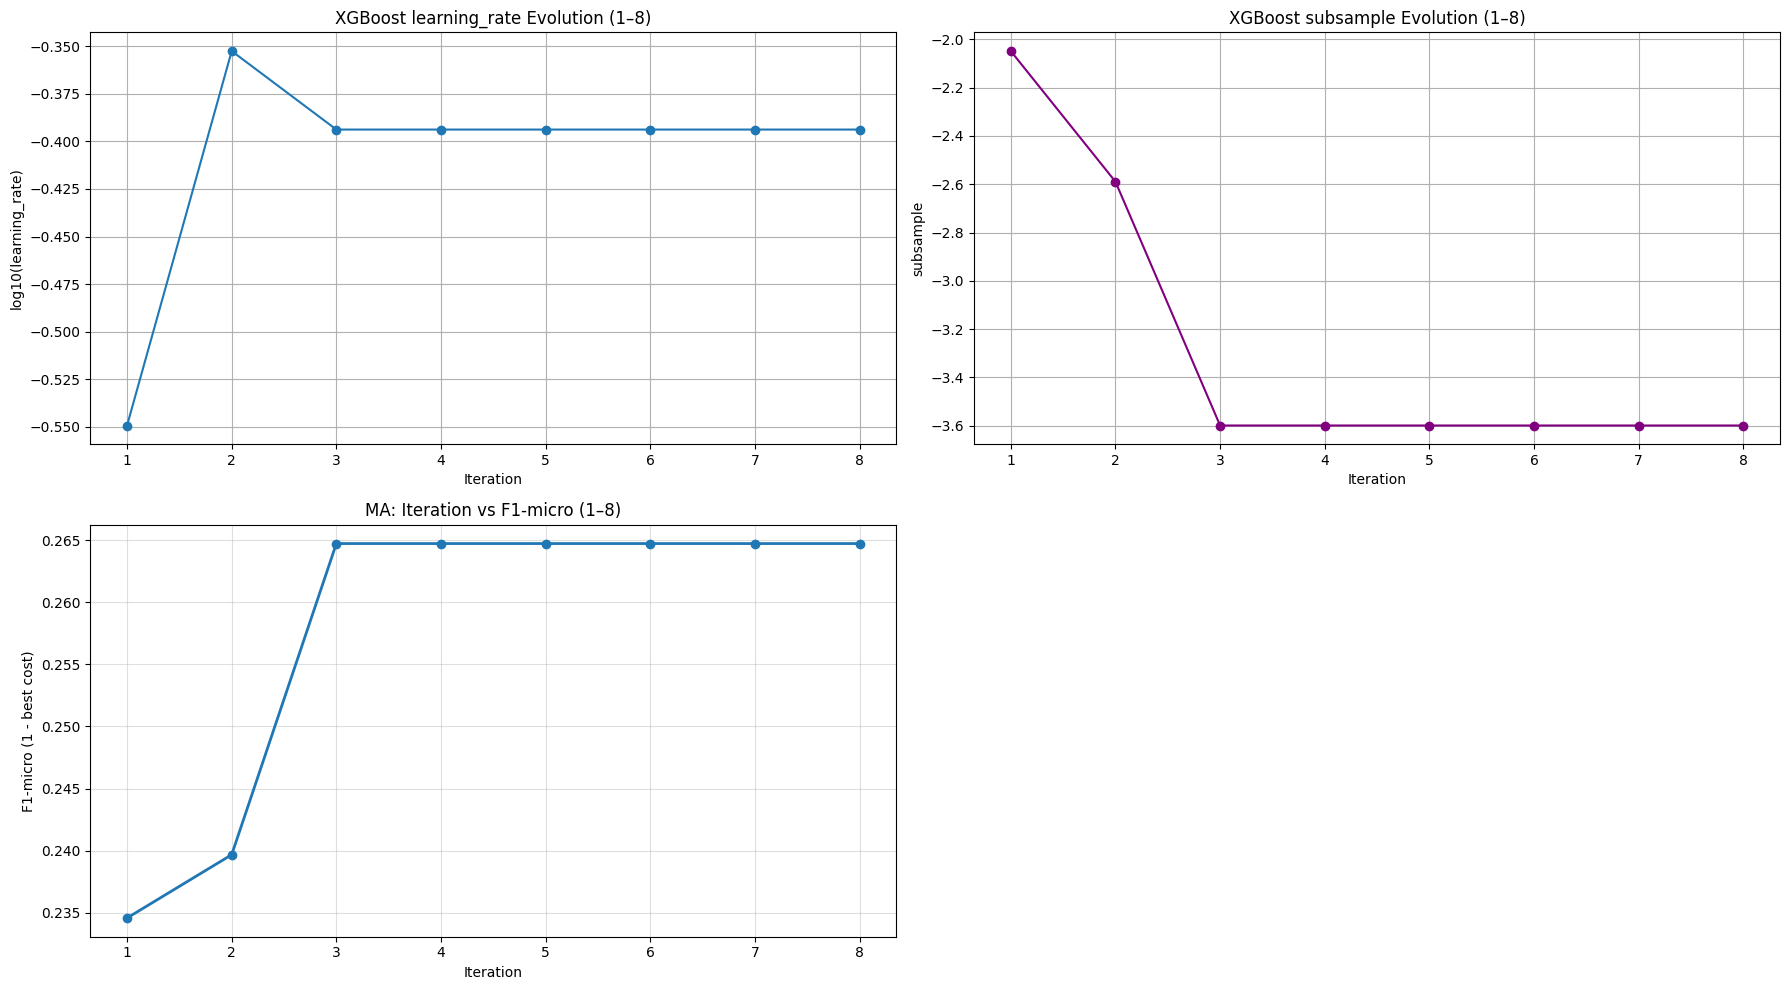

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))

# === ITER RANGE (only first 8) ===
max_iter_to_plot = 8


# --- Plot 1: log10(learning_rate) ---
plt.subplot(2,2,1)

if 'history_log10_lr' in globals() and len(history_log10_lr) > 0:
    N = min(max_iter_to_plot, len(history_log10_lr))
    iters = list(range(1, N + 1))
    plt.plot(iters, history_log10_lr[:N], marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("log10(learning_rate)")
    plt.title("XGBoost learning_rate Evolution (1–8)")
    plt.grid(True)
else:
    plt.text(0.5, 0.5, "history_log10_lr missing", ha='center')



# --- Plot 3: subsample ---
plt.subplot(2,2,2)

if 'history_subsample' in globals() and len(history_subsample) > 0:
    N = min(max_iter_to_plot, len(history_subsample))
    iters = list(range(1, N + 1))
    plt.plot(iters, history_subsample[:N], marker='o', color='purple')
    plt.xlabel("Iteration")
    plt.ylabel("subsample")
    plt.title("XGBoost subsample Evolution (1–8)")
    plt.grid(True)
else:
    plt.text(0.5, 0.5, "history_subsample missing", ha='center')



# --- Plot: F1 micro (hardcoded from logs, now sliced to first 8) ---
plt.subplot(2,2,3)

iters = list(range(1, max_iter_to_plot + 1))
costs = [0.76543, 0.76033, 0.73526, 0.73526, 0.73526,
         0.73526, 0.73526, 0.73526, 0.73526, 0.73526]

costs = costs[:max_iter_to_plot]           # only first 8
f1_micro = [1.0 - c for c in costs]

plt.plot(iters, f1_micro, marker='o', linestyle='-', linewidth=2)
plt.xticks(iters)
plt.xlabel("Iteration")
plt.ylabel("F1-micro (1 - best cost)")
plt.title("MA: Iteration vs F1-micro (1–8)")
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()
